In [1]:
from utils2 import getSynteticData, SNSMultipleboxPlot, ttests, MWU, exactTest, getErrors
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind
from significance_of_mean_cuda import significance_of_mean_cuda
import pandas as pd

In [2]:
%load_ext cython
%load_ext rpy2.ipython



R[write to console]: Warning:
R[write to console]:  namespace ‘pbdZMQ’ is not available and has been replaced
by .GlobalEnv when processing object ‘.pbd_env’

/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [3]:
%%R

require(ggplot2)
install.packages("devtools")
library("devtools")
install_github("bdsegal/fastPerm")

library(fastPerm)

R[write to console]: Loading required package: ggplot2

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/devtools_2.3.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 375227 bytes (366 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

In [4]:
%%R
    runFastPerm <- function(x,y,output, n_samples) {
        e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
      
            mStopDiffMean(x[[i]], y[[i]])
            valX = fastPerm(x[[i]], y[[i]], testStat = diffMean)
            
            valX <-unlist(valX)

      
            output[[i]] <- as.numeric(valX[1])
      
            }
    

    return(output)


    }

In [5]:
def fastPerm(A,B):
    x = pd.DataFrame(A, columns=list(range(A.shape[1]))).T
    y = pd.DataFrame(B, columns=list(range(B.shape[1]))).T
    n_samples = x.shape[1]
    outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T
    
    %R -i x
    %R -i y
    %R -i outputDf
    %R -i n_samples
    
    
    %R out <- runFastPerm(x,y, outputDf, n_samples)
    
    
    %R -o out
    return list(out.T["output"].values)

In [8]:
def getPvalues(mean=0.2):
    allFracList1 = list()
    allFracMWUList1 = list()
    allFracFPList1 = list()
    for setS in setSize:
        Anorm0, Bnorm0 = getSynteticData(np.random.normal, mean=mean, setN=setS,sampleN=50)
        ptTest  = ttests(Anorm0, Bnorm0)
    
        peList = exactTest(Anorm0, Bnorm0, bins=30)
        ExactFracList = getErrors(peList, ptTest, False) 
        allFracList1.append(np.log10(ExactFracList))
    
        pmwList = MWU(Anorm0, Bnorm0)
        MWUFracList = getErrors(pmwList, ptTest, False) 
        allFracMWUList1.append(np.log10(np.abs(MWUFracList)))
    

        ptfp = fastPerm(np.array(Anorm0), np.array(Bnorm0))
        FPFracList = getErrors(ptfp, ptTest, False)
        allFracFPList1.append(np.log10(FPFracList))
    
    return allFracList1, allFracMWUList1, allFracFPList1

def getNwPlot(setSize, mean=0.1):
    N_w = list(range(5, 105,5))
    allEerrorNw, allEerrorNwFrac = list(), list()
    for n_w in N_w:
        Anorm0, Bnorm0 = getSynteticData(np.random.normal, mean=mean, setN=setSize,sampleN=50)
        ptTest  = ttests(Anorm0, Bnorm0)
    
        peList = exactTest(Anorm0, Bnorm0, bins=n_w)
        ExactErrorList = getErrors(peList, ptTest)
        ExactFracList = getErrors(peList, ptTest, False) 
        allEerrorNw.append(np.log10(np.abs(ExactErrorList)))
        allEerrorNwFrac.append(np.log10(ExactFracList))
    return allEerrorNwFrac, N_w
    
    

In [ ]:
setSize = [10,50,100,150,200,250,300]

In [9]:
allFracList1, allFracMWUList1, allFracFPList1 = getPvalues()

In [10]:
!ls "./figures/accuracy/accuracy/"

ls: cannot access './figures/accuracy/accuracy/': No such file or directory


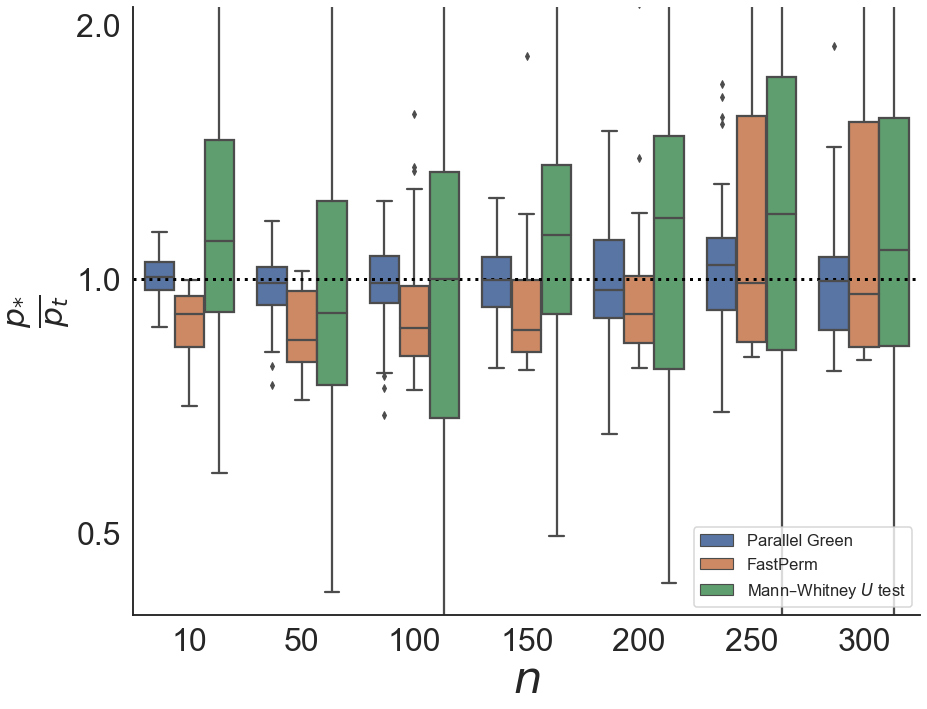

In [11]:
SNSMultipleboxPlot(allFracList1, setSize, allFracMWUList1, 
                   allFracFPList1, 
                   relError=False,
                   path="./figures/accuracy/02",
                  dashed=True,ylim=[0.4, 2.1])

In [12]:
allFracList2, allFracMWUList2, allFracFPList2 = getPvalues(1)

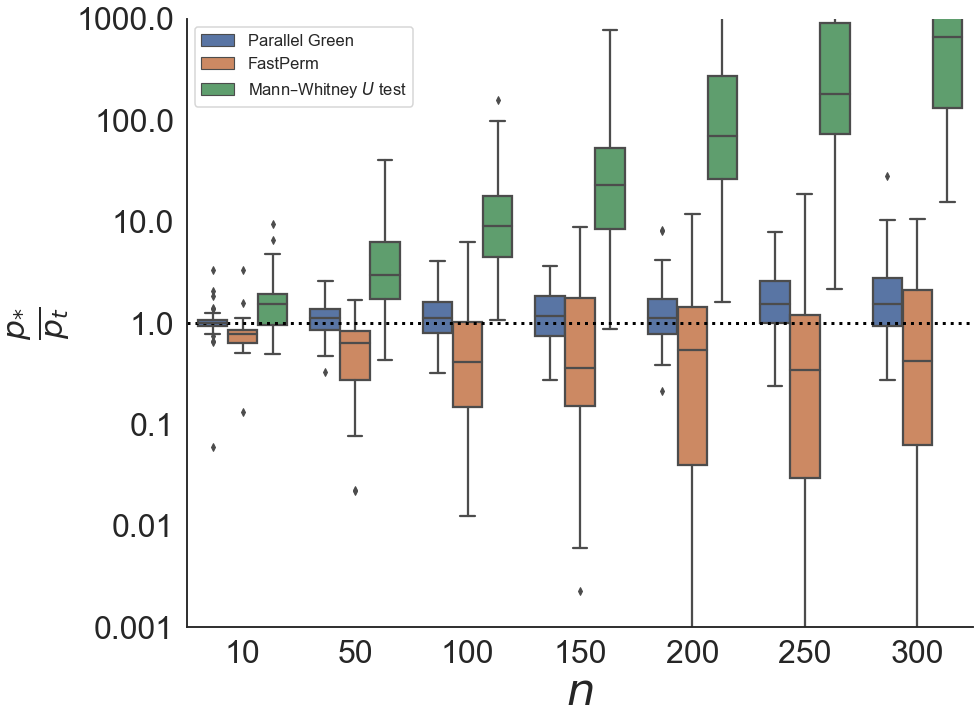

In [13]:
SNSMultipleboxPlot(allFracList2, setSize, allFracMWUList2, 
                   allFracFPList2, relError=False,path="./figures/accuracy/comparison/1", 
                   dashed=True, ylim=[10**-3, 10**3])



# |A|=|B|=150 $\mu = 1$

In [14]:
n3 = setSize[3]; n3

150

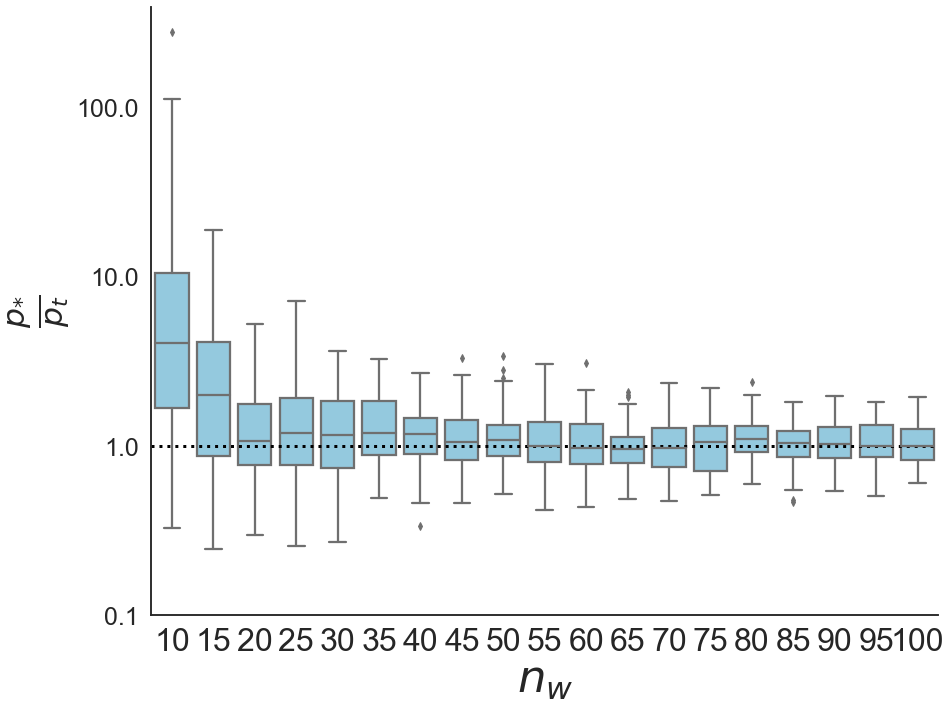

In [15]:
allEerrorNwFrac3_m_1, N_w = getNwPlot(n3, 1)

SNSMultipleboxPlot(allEerrorNwFrac3_m_1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n3),
                  dashed=True)

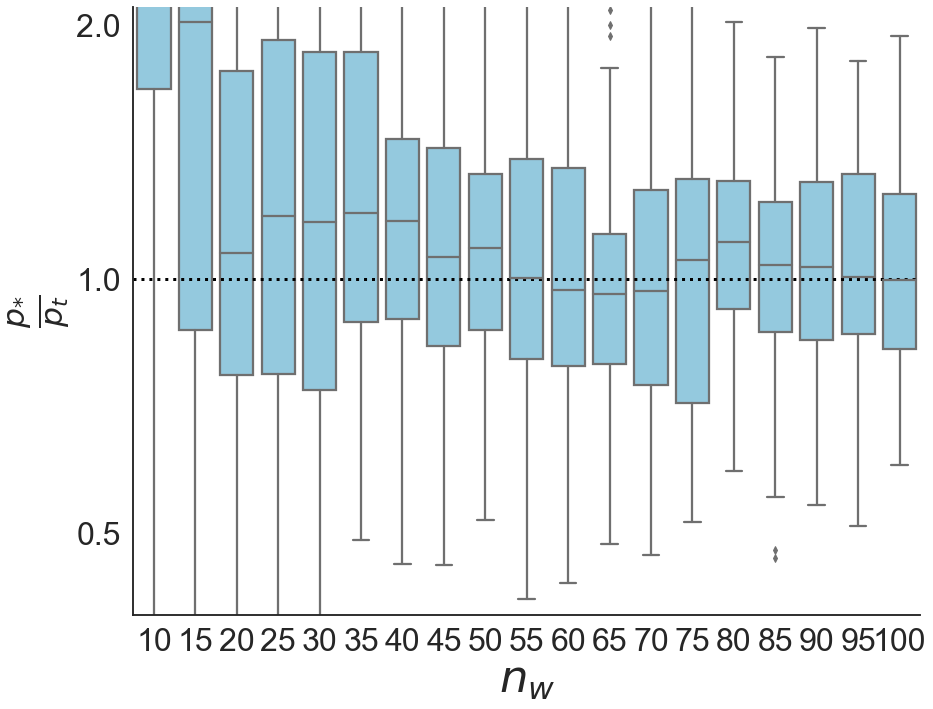

In [16]:
SNSMultipleboxPlot(allEerrorNwFrac3_m_1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n3),
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=150 $\mu = 0.2$

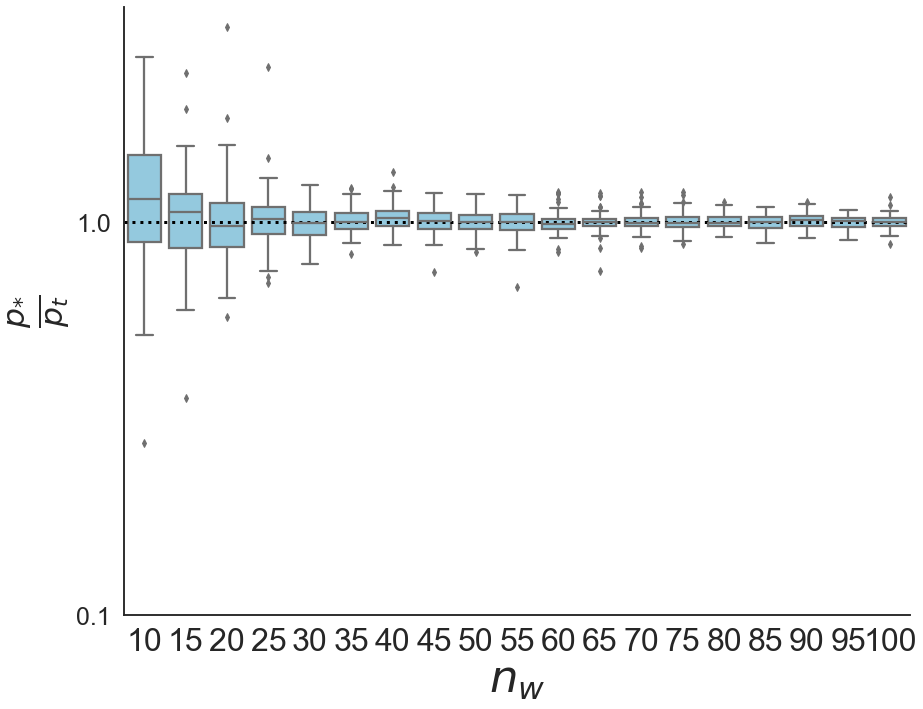

In [17]:
allEerrorNwFrac3_m_02, N_w = getNwPlot(n3, 0.2)

SNSMultipleboxPlot(allEerrorNwFrac3_m_02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n3),
                  dashed=True)

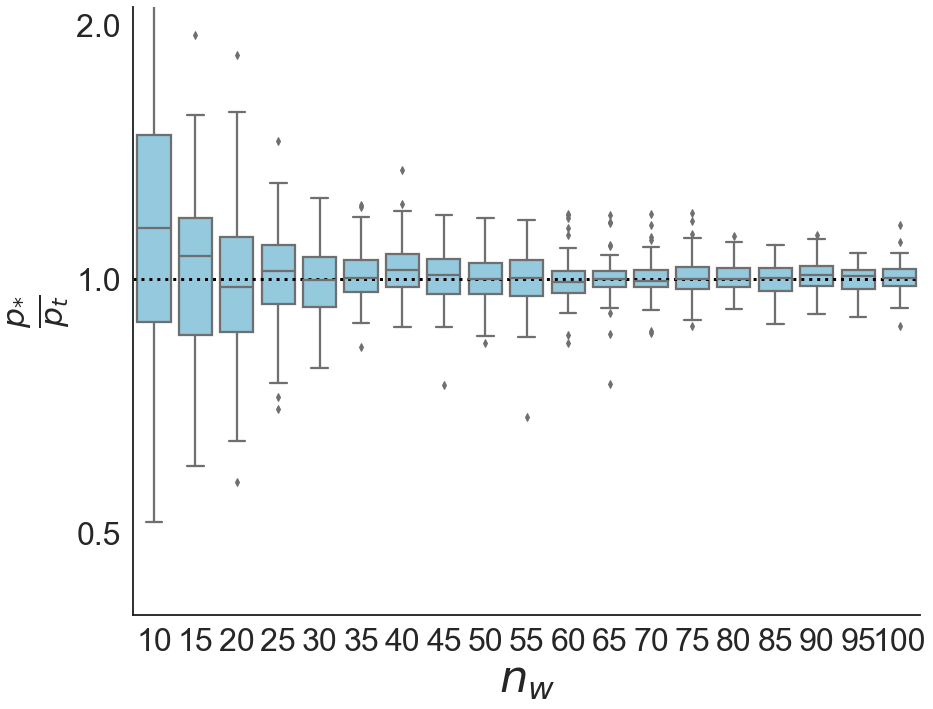

In [18]:
SNSMultipleboxPlot(allEerrorNwFrac3_m_02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n3),
                  dashed=True, ylim=[0.4, 2.1])